AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST veri seti ve DataLoader
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [01:18<00:00, 126kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 140kB/s]
100%|██████████| 1.65M/1.65M [00:26<00:00, 62.2kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.20MB/s]


In [2]:
# Autoencoder modeli
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # latent space
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # 0-1 arası çıktı
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [3]:
# Model, loss ve optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch [1/5], Loss: 0.0612
Epoch [2/5], Loss: 0.0314
Epoch [3/5], Loss: 0.0253
Epoch [4/5], Loss: 0.0216
Epoch [5/5], Loss: 0.0192


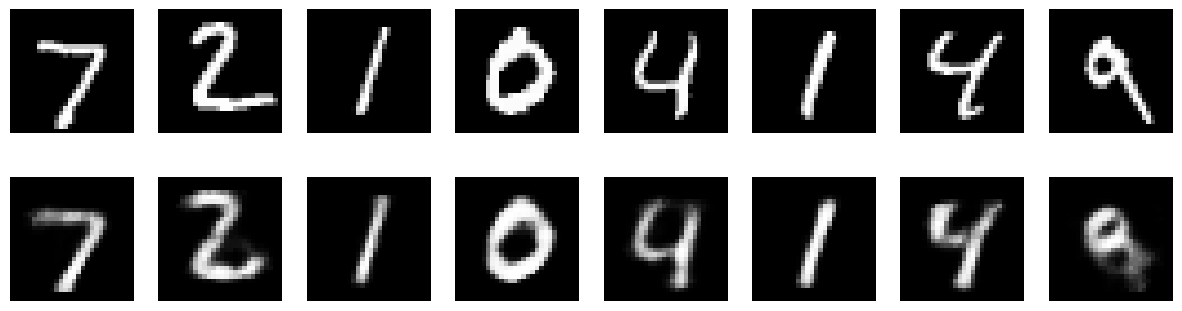

In [4]:
# Eğitim döngüsü
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Test ve görselleştirme
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        # İlk 8 örneği görselleştir
        fig, axes = plt.subplots(2, 8, figsize=(15,4))
        for i in range(8):
            axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[0,i].axis('off')
            axes[1,i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
            axes[1,i].axis('off')
        plt.show()
        break